#**Pennsylvania Retail Electricity Market Analysis**

This notebook analyzes the retail electricity market in Pennsylvania, focusing on comparing utility default service rates (Standard Service Offer - SSO) with
competitive retail electricity supplier (CRES) offerings.

## **Setup and configuration**
First, we import necessary libraries and set up our environment with proper
plotting configurations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import os

# configuration parameters
CONFIG = {
    'start_year': 2017,
    'end_year': 2023,
    'utility_name':'PECO Energy',
    'rate_type': 'default rate',
    'base_dir': "/content/drive/MyDrive/CSE 280",
    'dataset': "/content/drive/MyDrive/CSE 280/WattBuyData1999_2024.pkl",
    'wholesale_dataset':"/content/drive/MyDrive/CSE 280/pjmdata_daily_medians_2017_2023.pkl"
}

### **Directory setup**
create necessary directories for storing analysis results.

In [2]:
def setup_directories(base_dir):
    """
    create and configure directories for analysis outputs.
    args:
        base_dir (str): base directory path
    returns:
        dict: dictionary containing paths to various directories
    """
    analysis_dir = os.path.join(base_dir, "pa_retail_analysis")

    if not os.path.exists(analysis_dir):
        os.makedirs(analysis_dir)
        print(f"created analysis directory at: {analysis_dir}")
    else:
        print(f"analysis directory already exists at: {analysis_dir}")

    return {
        "base_dir": base_dir,
        "analysis_dir": analysis_dir
    }

### **Plot Style Configuration**
Set up matplotlib parameters for publication-quality figures.

In [3]:
def setup_plot_style():
    """
    configure matplotlib parameters for publication-quality plots.
    sets font family, size, and other visual parameters.
    """
    pd.plotting.register_matplotlib_converters()
    # rc('font', **{'family': 'Computer Modern Roman'})
    # # rc('text', usetex=True)

    plt.style.use('seaborn-v0_8-whitegrid')
    # plt.rcParams.update({
    #     'font.size': 12,
    #     'axes.labelsize': 14,
    #     'axes.titlesize': 16,
    #     'xtick.labelsize': 12,
    #     'ytick.labelsize': 12,
    #     'legend.fontsize': 12,
    #     'figure.dpi': 300,
    #     'savefig.dpi': 300,
    #     'figure.figsize': (10, 6),
    #     'axes.grid': True,
    #     'grid.alpha': 0.3
    # })

In [4]:
DIRS = setup_directories(CONFIG['base_dir'])
setup_plot_style()

analysis directory already exists at: /content/drive/MyDrive/CSE 280/pa_retail_analysis


## **Data loading**
In this section, we will load the dataset from the the pickle file

In [5]:
def load_data(filepath):
    """
    load dataset from a pickle file.
    args:
        filepath (str): path to the dataset file.
    returns:
        pd.DataFrame: loaded dataset.
    """
    return pd.read_pickle(filepath)

## **Data Preprocessing**
In this section, we apply filtering and transformations to prepare the dataset for downstream analysis.

In [6]:
def strip_spaces(df, columns):
    """
    Strips leading and trailing spaces from the specified columns in a df

    Parameters:
    df (pd.DataFrame): The DataFrame to modify.
    columns (list): List of column names to strip spaces from.

    Returns:
    pd.DataFrame: DataFrame with spaces removed from specified columns.
    """
    df = df.copy()
    for col in columns:
        df[col] = df[col].astype(str).str.strip()
    return df

In [7]:
def filter_by_year(df, start_year, end_year):
    """
    filter dataset to include only records within the specified year range.
    args:
        df (pd.DataFrame): input dataset.
        start_year (int): start year for filtering.
        end_year (int): end year for filtering.
    returns:
        pd.DataFrame: filtered dataset.
    """
    return df[(df['created_at'].dt.year >= start_year) &
              (df['created_at'].dt.year <= end_year)].copy()

In [8]:

def filter_default_rates_by_rate_type(df, rate_type):
    """
    filter dataset to retain only default rates of a specified type.
    args:
        df (pd.DataFrame): input dataset.
        rate_type (str): rate type to filter
    returns:
        pd.DataFrame: filtered dataset containing only the specified default rates.
    """
    return df[df['utility_rate_type'] == rate_type].copy()

In [9]:
def filter_suppliers_by_invariant_features(df):
    """
    filter suppliers based on predefined invariant features. These were the features
    that we agreed can be used to make the competitive plans comparable to the
    default rates.

    args:
        df (pd.DataFrame): input dataset.
    returns:
        pd.DataFrame: filtered supplier dataset.
    """
    filter_conditions = {
        "rate_type_plan": ["fixed"],
        "term": [12.0],
        "service_type": ["residential"],
        "monthly_charge_amount": [0.0, None, np.nan],
        "early_term_fees_min_value": [0.0, None, np.nan]
    }

    for column, values in filter_conditions.items():
        df = df[df[column].isin(values)]

    return df.drop_duplicates()

In [10]:
def convert_rates(df, rate_columns):
    """
    convert rate values from cents to dollars.
    args:
        df (pd.DataFrame): input dataset.
        rate_columns (list): list of columns to convert.
    returns:
        pd.DataFrame: dataset with converted rates.
    """
    for col in rate_columns:
        df.loc[:, col] = df[col] / 100 # the rates are in c/kWh so we use 100c to convert them to dollars
    return df

In [196]:
def impute_wholesale_data(df_wholesale):
    """
    impute missing values in wholesale data on a daily basis by utility name.

    Args:
        df_wholesale (pd.DataFrame): Wholesale dataframe with utility_name, lmp, and created_at columns.

    Returns:
        pd.DataFrame: Imputed wholesale dataframe with no missing dates.
    """
    # convert created_at to datetime if not already
    df_wholesale['created_at'] = pd.to_datetime(df_wholesale['created_at'])

    # group by utility_name
    grouped = df_wholesale.groupby('utility_name')
    imputed_groups = []

    for utility_name, group in grouped:
        # sort by date and retain only the latest entry per date
        group = group.sort_values('created_at').drop_duplicates(subset='created_at', keep='last')

        # define the full date range for imputation
        start_date = group['created_at'].min()
        end_date = group['created_at'].max()
        daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')

        # reindex data to include all daily dates and forward fill missing values
        group = group.set_index('created_at').reindex(daily_dates).ffill()

        # reset index and maintain column names
        group = group.reset_index().rename(columns={'index': 'created_at'})
        group['utility_name'] = utility_name

        imputed_groups.append(group)

    # combine imputed groups and sort
    df_imputed_wholesale = pd.concat(imputed_groups, ignore_index=True)
    df_imputed_wholesale = df_imputed_wholesale.sort_values(['utility_name', 'created_at']).reset_index(drop=True)

    return df_imputed_wholesale

In [169]:
def impute_data_with_daily_prices(group):
    """
    impute missing daily data for each utility group.
    the assumption is that the last known default rate remains unchanged until
    a new rate is provided. Thus, all missing rates are filled using forward fill.

    args:
        group (pd.DataFrame): grouped data by utility.
    returns:
        pd.DataFrame: dataset with imputed daily values.
    """
    # extract utility name and rate type
    utility_name = group['utility_name'].iloc[0]
    utility_rate_type = group['utility_rate_type'].iloc[0]

    # sort by date and retain only the latest entry per date
    group = group.sort_values('created_at').drop_duplicates(subset='created_at', keep='last')

    # define the full date range for imputation
    start_date = group['created_at'].min()
    end_date = group['created_at'].max()
    daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # reindex data to include all daily dates and forward fill missing values
    group = group.set_index('created_at').reindex(daily_dates).ffill()

    # reset index and maintain column names
    group = group.reset_index().rename(columns={'index': 'created_at'})
    group['utility_name'] = utility_name
    group['utility_rate_type'] = utility_rate_type

    return group

In [197]:
def preprocess_data(df, df_wholesale, config):
    """
    apply preprocessing steps including filtering, rate conversion, and imputation.

    args:
        df (pd.DataFrame): raw dataset.
        config (dict): configuration parameters.

    returns:
        pd.DataFrame: preprocessed dataset.
    """
    # clean the names
    df = strip_spaces(df, ['utility_name', 'supplier_name'])

    # filter dataset by year
    df_filtered = filter_by_year(df, config['start_year'], config['end_year'])
    df_wholesale_filtered = filter_by_year(df_wholesale, config['start_year'], config['end_year'])

    # filter for default provider rates
    default_rates_with_suppliers = filter_default_rates_by_rate_type(df_filtered, config['rate_type'])

    # normalize service_type values
    default_rates_with_suppliers['service_type'] = (
        default_rates_with_suppliers['service_type']
        .astype(str)  # convert to string to handle NaN
        .str.strip()  # remove leading/trailing spaces
        .apply(lambda x: x.lower() if x.lower() != 'nan' else np.nan)
    )

    # extract the columns belonging to default utility provider
    default_utility_providers_filtered = default_rates_with_suppliers[[
        'utility_id', 'utility_name', 'utility_rate_type', 'created_at',
        'utility_rate_from_value', 'utility_rate_to_value', 'utility_rate_amount',
    ]].copy()

    # use the default rates dataset to get suppliers linked to the filtered default utility providers above
    suppliers_linked_to_default_utility_providers = default_rates_with_suppliers.copy()

    # filter competitive supplier plans based on invariant features
    comparable_suppliers = filter_suppliers_by_invariant_features(suppliers_linked_to_default_utility_providers)

    # remove columns that already exist in default rates before merging
    columns_to_exclude = set(default_utility_providers_filtered.columns)  # columns already in default utility providers
    supplier_columns = [col for col in comparable_suppliers.columns if col not in columns_to_exclude]

    # final merged df
    final_df = default_utility_providers_filtered.merge(
        comparable_suppliers[['utility_id', 'created_at'] + supplier_columns],
        on=['utility_id', 'created_at'], how='left'
    )

    # drop all duplicated records
    default_rates_with_comparable_suppliers = final_df #final_df.drop_duplicates()

    # convert rate values to dollars
    default_rates_with_comparable_suppliers = convert_rates(default_rates_with_comparable_suppliers, ['utility_rate_amount', 'plan_rate_amount'])

    # group default rates by utility and rate type for imputation
    pd.set_option('future.no_silent_downcasting', True)
    grouped = default_rates_with_comparable_suppliers.groupby(['utility_name', 'utility_rate_type'])
    imputed_groups = []

    for _, group in grouped:
        imputed_group = impute_data_with_daily_prices(group)
        imputed_groups.append(imputed_group)

    # combine and sort
    df_imputed = pd.concat(imputed_groups, ignore_index=True)
    df_combined = df_imputed.sort_values(['utility_name', 'utility_rate_type', 'created_at']).reset_index(drop=True)

    # impute the whole sale prices
    df_wholesale_imputed = impute_wholesale_data(df_wholesale_filtered)
    return df_combined, df_wholesale_imputed

## **Data Analysis**
In this section, we analyze the preprocessed dataset

In [198]:
def calculate_median_rates(df_combined, df_wholesale, utility_name, utility_rate_col, supplier_rate_col):
    """
    Calculate median rate comparison between a specified utility and suppliers.

    Args:
        df_combined (DataFrame): Dataframe containing utility and supplier rate data.
        utility_name (str): Name of the utility to filter data.
        utility_rate_col (str): Column name for the utility's rate amount.
        supplier_rate_col (str): Column name for the supplier's rate amount.
    Returns:
        tuple: DataFrames of median rates for utility and suppliers.
    """
    df = df_combined.copy()

    df_wholesale = df_wholesale.copy()

    # filter for the specified utility
    utility_data = df[df['utility_name'] == utility_name].copy()

    wholesale_data = df_wholesale[df_wholesale['utility_name'] == utility_name].copy()

    # convert created_at to datetime if it isn't already
    utility_data['created_at'] = pd.to_datetime(utility_data['created_at'])

    # create month_year column for grouping
    utility_data['month_year'] = utility_data['created_at'].dt.to_period('M')

    wholesale_data['month_year'] = wholesale_data['created_at'].dt.to_period('M')

    # calculate medians
    utility_medians = (utility_data[utility_data['utility_name'].notna()]
                      .groupby('month_year')[utility_rate_col]
                      .median()
                      .reset_index())

    supplier_medians = (utility_data[utility_data['supplier_name'].notna()]
                       .groupby('month_year')[supplier_rate_col]
                       .median()
                       .reset_index())

    wholesale_medians = (wholesale_data[wholesale_data['utility_name'].notna()]
                        .groupby('month_year')['lmp']
                        .median()
                        .reset_index())

    # convert month_year to timestamp for plotting
    utility_medians['month_year'] = utility_medians['month_year'].dt.to_timestamp()
    supplier_medians['month_year'] = supplier_medians['month_year'].dt.to_timestamp()
    wholesale_medians['month_year'] = wholesale_medians['month_year'].dt.to_timestamp()

    return utility_medians, supplier_medians, wholesale_medians

In [199]:
def plot_median_rates_prices_and_wholesale_prices(utility_medians, supplier_medians, wholesale_prices, title, x_label, y_label, legend_labels):
    """
    plot median rate comparison between utility, suppliers, and wholesale prices

    args:
        utility_medians (DataFrame): dataframe containing median utility rates
        supplier_medians (DataFrame): dataframe containing median supplier rates
        wholesale_prices (DataFrame): dataframe containing wholesale prices
        title (str): title of the plot
        x_label (str): label for the x-axis
        y_label (str): label for the y-axis
        legend_labels (tuple): labels for wholesale, supplier, and utility lines
    """
    # Create copies to avoid modifying original dataframes
    utility_df = utility_medians.copy()
    supplier_df = supplier_medians.copy()
    wholesale_df = wholesale_prices.copy() if not wholesale_prices.empty else pd.DataFrame()

    # Convert PeriodDtype to timestamps if needed
    if hasattr(utility_df['month_year'].dtype, 'freq'):  # Check if it's a PeriodDtype
        utility_df['month_year'] = utility_df['month_year'].dt.to_timestamp()

    if hasattr(supplier_df['month_year'].dtype, 'freq'):
        supplier_df['month_year'] = supplier_df['month_year'].dt.to_timestamp()

    if not wholesale_df.empty and hasattr(wholesale_df['month_year'].dtype, 'freq'):
        wholesale_df['month_year'] = wholesale_df['month_year'].dt.to_timestamp()

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    lines = []
    labels = []

    # plot wholesale prices on left y-axis if dataframe is not empty
    if not wholesale_df.empty:
        wholesale_line = ax1.plot(wholesale_df['month_year'], wholesale_df.iloc[:, 1],
                                label=legend_labels[0], color='red')
        ax1.set_ylabel('Wholesale Price ($/MWh)')
        lines.extend(wholesale_line)
        labels.append(legend_labels[0])

    # plot retail rates on right y-axis (convert to cents/kWh)
    supplier_line = ax2.plot(supplier_df['month_year'], supplier_df.iloc[:, 1] * 100,
                           label=legend_labels[1], color='blue')
    utility_line = ax2.plot(utility_df['month_year'], utility_df.iloc[:, 1] * 100,
                          label=legend_labels[2], color='green')
    ax2.set_ylabel('Retail Price (¢/kWh)')

    lines.extend(supplier_line)
    lines.extend(utility_line)
    labels.extend([legend_labels[1], legend_labels[2]])

    # Get all unique years from all datasets
    all_dates = pd.concat([
        utility_df['month_year'],
        supplier_df['month_year']
    ])
    if not wholesale_df.empty:
        all_dates = pd.concat([all_dates, wholesale_df['month_year']])

    years = sorted(set(date.year for date in pd.to_datetime(all_dates)))

    # Create tick positions as pandas Timestamps
    tick_positions = []
    tick_labels = []
    for year in years:
        months = [1, 7, 12] if year == years[-1] else [1, 7]
        for month in months:
            tick_positions.append(pd.Timestamp(f'{year}-{month:02d}-01'))
            tick_labels.append(f'{year}-{month:02d}')

    # Set the tick positions - using your original approach
    ax1.set_xticks(tick_positions)
    ax1.set_xticklabels(tick_labels, rotation=90)

    # customize grid and labels as original
    ax1.grid(True, axis='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    ax1.set_title(title, loc='left')
    ax1.set_xlabel(x_label)

    # move legend below as original with explicit order
    ax1.legend(lines, labels, bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=3)
    plt.subplots_adjust(bottom=0.2)  # Keeping your original adjustment

In [200]:
def calculate_price_distribution(df_combined, utility_name, utility_medians):
    """
    determines the number of suppliers that are below or above a specified utility
    args:
        df_combined (DataFrame): dataframe containing utility and supplier rate data
        utility_name (str): name of the utility to filter data
        utility_medians (DataFrame): dataframe containing median utility rates (used for graphs)
    """
    # filter for the specified utility
    utility_data = df_combined[df_combined['utility_name'] == utility_name].copy()

    # convert created_at to datetime if it is not already
    utility_data['created_at'] = pd.to_datetime(utility_data['created_at'])
    utility_data['date'] = utility_data['created_at'].dt.date

    # get daily utility rates
    daily_utility_rates = utility_data[utility_data['utility_name'].notna()].groupby('date')['utility_rate_amount'].first().reset_index()

    # filter only supplier data
    supplier_data = utility_data[utility_data['supplier_name'].notna()].copy()

    # map daily utility rates to supplier data
    supplier_data['default_rate'] = supplier_data['date'].map(
        daily_utility_rates.set_index('date')['utility_rate_amount']
    )

    # remove records with missing default rates
    supplier_data = supplier_data.dropna(subset=['default_rate'])

    below_or_equal = (supplier_data['plan_rate_amount'] <= supplier_data['default_rate']).sum()
    above = (supplier_data['plan_rate_amount'] > supplier_data['default_rate']).sum()

    return below_or_equal, above

In [201]:
def plot_price_distribution(below_or_equal, above, utility_name):
    """
    plot bar chart of price distribution

    args:
        below_or_equal (int): count of supplier prices below or equal to SSO
        above (int): count of supplier prices above the SSO
        utility_name (str): name of the utility for title
    """
    title = f'Frequency of CRES Offers Exceeding SSO in {utility_name}'
    fig, ax = plt.subplots(figsize=(10, 6))

    # data for bars
    data = [below_or_equal, above]
    labels = ['Price equal or\nbelow SSO', 'Price exceeding\nthe SSO']
    colors = ['#808080', 'red']

    # create bars
    bars = ax.bar(labels, data, color=colors)

    # add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{int(height):,}\n({height/sum(data):.1%})',
                ha='center', va='bottom')

    # customize grid and labels
    ax.grid(True, axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.set_title(title, loc='left', pad=20)
    ax.set_ylabel('Number of Offers')

    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

In [202]:
def calculate_yearly_markup(df_combined, utility_name, utility_medians):
    """
    calculates the median markup trend for competitive offers compared to standard offer

    args:
        df_combined (DataFrame): dataframe containing utility and supplier rate data
        utility_name (str): name of the utility to filter data
        utility_medians (DataFrame): dataframe containing median utility rates

    returns:
        Series: yearly median markup values
    """
    utility_data = df_combined[df_combined['utility_name'] == utility_name].copy()
    utility_data['created_at'] = pd.to_datetime(utility_data['created_at'])
    utility_data['month_year'] = utility_data['created_at'].dt.to_period('M')
    supplier_data = utility_data[utility_data['supplier_name'].notna()].copy()

    # convert utility_medians month_year to period for proper mapping
    utility_medians = utility_medians.copy()
    utility_medians['month_year'] = pd.to_datetime(utility_medians['month_year']).dt.to_period('M')

    supplier_data['default_rate'] = supplier_data['month_year'].map(
        utility_medians.set_index('month_year')['utility_rate_amount']
    )

    # calculate markup percentage
    supplier_data['markup'] = ((supplier_data['plan_rate_amount'] - supplier_data['default_rate']) /
                              supplier_data['default_rate']) * 100

    supplier_data['year'] = supplier_data['created_at'].dt.year
    yearly_markup = supplier_data.groupby('year')['markup'].median()

    return yearly_markup

In [203]:
def plot_markup_trend(yearly_markup, utility_name):
    """
    plots the median markup/discount trend over time for a specified utility

    args:
        yearly_markup (Series): yearly median markup/discount values
        utility_name (str): name of the utility to include in the title
    """
    title = f'12-Month CRES Offers Rates Exceeding the SSO in {utility_name}'

    fig, ax = plt.subplots(figsize=(10, 6))

    # plot filled area above 0%
    ax.fill_between(yearly_markup.index,
                    yearly_markup.values,
                    0,
                    where=(yearly_markup.values >= 0),
                    color='grey',
                    alpha=0.3,
                    interpolate=True)

    # plot main line with points
    ax.plot(yearly_markup.index, yearly_markup.values, color='red', linewidth=2)
    ax.scatter(yearly_markup.index, yearly_markup.values, color='red', s=50)

    # add horizontal dotted line at 0%
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

    ax.set_title(title, loc='left')
    ax.set_xlabel('Delivery Year')
    ax.set_ylabel('Magnitude (%)')

    ax.set_xticks(yearly_markup.index)
    ax.set_xticklabels(yearly_markup.index, rotation=0)

    ax.grid(True, axis='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [204]:
def calculate_utility_frequencies(df_combined):
    """
    calculates the average net annual frequency of CRES offers exceeding the SSO for all utilities

    args:
        df_combined (DataFrame): dataframe containing utility and supplier rate data

    returns:
        DataFrame: average net annual frequency for each utility
    """
    df_combined['created_at'] = pd.to_datetime(df_combined['created_at'])
    utility_frequencies = []

    for utility in df_combined['utility_name'].unique():
        utility_data = df_combined[df_combined['utility_name'] == utility].copy()
        annual_frequencies = []

        for year in df_combined['created_at'].dt.year.unique():
            year_data = utility_data[utility_data['created_at'].dt.year == year].copy()

            if len(year_data[year_data['supplier_name'].notna()]) > 0:
                # get supplier and utility rates for the entire year
                supplier_data = year_data[year_data['supplier_name'].notna()].copy()
                utility_median = year_data[year_data['utility_name'].notna()]['utility_rate_amount'].median()

                if len(supplier_data) > 0:

                    # number of plan rate amount exceeding the default utility median
                    exceeding = len(supplier_data[supplier_data['plan_rate_amount'] > utility_median])
                    total = len(supplier_data)

                    # calculate the net annual frequency for that yea
                    annual_frequency = (exceeding / total) * 100
                    annual_frequencies.append(annual_frequency)

        # find the net average annual frequency
        avg_net_frequency = sum(annual_frequencies) / len(annual_frequencies) if annual_frequencies else 0
        utility_frequencies.append({'utility': utility, 'frequency': avg_net_frequency})

    return pd.DataFrame(utility_frequencies)

In [205]:
def calculate_annual_frequencies(df_combined, utility_name):
    """
    calculates annual frequency of CRES offers exceeding the SSO for a specified utility

    args:
        df_combined (DataFrame): dataframe containing utility and supplier rate data
        utility_name (str): name of the utility to filter data

    returns:
        DataFrame: annual frequency of CRES offers exceeding the SSO for the specified utility
    """
    df_combined = df_combined.copy()
    df_combined['created_at'] = pd.to_datetime(df_combined['created_at'])
    df_combined['date'] = df_combined['created_at'].dt.date
    utility_frequencies = []

    # filter for utility
    utility_data = df_combined[df_combined['utility_name'] == utility_name].copy()

    for year in df_combined['created_at'].dt.year.unique():
        # filter data for current year
        year_data = utility_data[utility_data['created_at'].dt.year == year].copy()

        if len(year_data[year_data['supplier_name'].notna()]) > 0:
            # get daily utility rates
            daily_utility_rates = year_data[year_data['utility_name'].notna()].groupby('date')['utility_rate_amount'].first().reset_index()

            # get supplier data
            supplier_data = year_data[year_data['supplier_name'].notna()].copy()

            # map daily utility rates to supplier data
            supplier_data['utility_rate'] = supplier_data['date'].map(
                daily_utility_rates.set_index('date')['utility_rate_amount']
            )

            # remove any records with missing utility rates
            supplier_data = supplier_data.dropna(subset=['utility_rate'])

            if len(supplier_data) > 0:
                exceeding = len(supplier_data[supplier_data['plan_rate_amount'] > supplier_data['utility_rate']])
                total = len(supplier_data)
                annual_frequency = (exceeding / total) * 100
            else:
                annual_frequency = 0

            utility_frequencies.append({'year': year, 'frequency': annual_frequency})

    return pd.DataFrame(utility_frequencies)

In [206]:
def plot_utility_analysis(df_frequencies, df_annual_freq, utility_name):
    """
    creates side-by-side plots showing the average net annual frequency analysis

    args:
        df_frequencies (DataFrame): average net annual frequency of all utilities
        df_annual_freq (DataFrame): annual frequency of CRES offers exceeding the SSO for a specified utility
        utility_name (str): name of the utility to include in the title
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # first subplot - all utility frequencies
    ax1.bar(range(len(df_frequencies)), df_frequencies['frequency'], color='gray')
    ax1.set_title('Average Net Annual Frequency of CRES Offers Exceeding the SSO', loc='left')
    ax1.set_xlabel('Utility')
    ax1.set_ylabel('Average Frequency (%)')
    ax1.set_xticks(range(len(df_frequencies)))
    ax1.set_xticklabels(df_frequencies['utility'], rotation=90, ha='right')

    # second subplot - time series for the specified utility
    ax2.plot(df_annual_freq['year'], df_annual_freq['frequency'], color='red', linewidth=2)
    ax2.scatter(df_annual_freq['year'], df_annual_freq['frequency'], color='red', s=50)
    ax2.set_title(f'Annual Frequency of CRES Offers Exceeding the SSO for {utility_name}', loc='left')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Average Frequency (%)')
    ax2.grid(True, axis='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    ax2.set_xticks(df_annual_freq['year'])
    ax2.set_xticklabels(df_annual_freq['year'], rotation=0)

    plt.tight_layout()
    # plt.savefig(f'{utility_name.lower().replace(" ", "_")}_annual_freq_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

In [207]:
def calculate_annual_markup_savings(df_combined):
    """
    calculates annual markup and savings for each utility

    args:
        df_combined (DataFrame): dataframe containing utility and supplier rate data

    returns:
        DataFrame: contains average markup and savings for each utility
    """
    df_combined['created_at'] = pd.to_datetime(df_combined['created_at'])
    df_combined['year'] = df_combined['created_at'].dt.year  # extract the year

    utility_stats = []

    for utility in df_combined['utility_name'].unique():
        annual_markups = []
        annual_savings = []

        # filter data for this utility
        utility_data = df_combined[df_combined['utility_name'] == utility].copy()

        for year in df_combined['year'].unique():
            year_data = utility_data[utility_data['year'] == year].copy()
            supplier_data = year_data[year_data['supplier_name'].notna()].copy()

            if len(supplier_data) == 0:
                continue  # skip if no supplier data

            # calculate the median utility rate for the entire year
            utility_median = year_data[year_data['utility_name'].notna()]['utility_rate_amount'].median()

            # assign the median utility rate to supplier data for comparison
            supplier_data['default_rate'] = utility_median

            # calculate the percentage difference between supplier rates and the median utility rate
            differences = ((supplier_data['plan_rate_amount'] - supplier_data['default_rate']) /
                           supplier_data['default_rate'] * 100)

            # calculate the average markup percentage for this year
            # this represents cases where suppliers charged more than the default rate
            year_markup = differences[differences > 0].mean()

            # calculate the average savings percentage for this year
            # this represents cases where suppliers charged less than the default rate
            year_savings = differences[differences < 0].mean()

            # add the values if they are not NaN (i.e., at least one value exists)
            if not pd.isna(year_markup):
                annual_markups.append(year_markup)
            if not pd.isna(year_savings):
                annual_savings.append(year_savings)

        # calculate average markup and savings across all years for this utility
        avg_markup = sum(annual_markups) / len(annual_markups) if annual_markups else 0
        avg_savings = sum(annual_savings) / len(annual_savings) if annual_savings else 0

        utility_stats.append({'utility': utility, 'markup': avg_markup, 'savings': avg_savings})

    return pd.DataFrame(utility_stats)

In [208]:
def plot_markup_savings(df_stats):
    """
    plots average rate markups and savings by utility

    args:
        df_stats (DataFrame): contains average markup and savings for each utility
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(df_stats))
    width = 0.35

    # plot markup and savings as grouped bar charts
    ax.bar(x - width/2, df_stats['markup'], width, label='average rate markup', color='grey')
    ax.bar(x + width/2, df_stats['savings'], width, label='average rate savings', color='red')

    ax.set_title('Average Rate Markups and Savings by Default Utility Provider', loc='left')
    ax.set_xlabel('Utility')
    ax.set_ylabel('Percentage (%)')
    ax.set_xticks(x)
    ax.set_xticklabels(df_stats['utility'], rotation=90, ha='right')
    ax.grid(axis='y', linestyle='-', alpha=0.4)
    ax.legend()

    plt.tight_layout()
    # plt.savefig('savings_markup.png', dpi=300, bbox_inches='tight')
    plt.show()

In [209]:
def create_daily_wholesale_prices(df_combined):
    """
    creates dummy daily wholesale prices

    args:
        df_combined (DataFrame): dataframe containing utility and supplier rate data

    returns:
        DataFrame: daily wholesale prices
    """
    df = df_combined.copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['date'] = df['created_at'].dt.date

    # get unique dates and sort them
    daily_dates = pd.DataFrame({'date': df['date'].unique()}).sort_values('date')

    # create wholesale prices in cents/kWh
    wholesale_prices = pd.DataFrame({
        'date': daily_dates['date'],
        'price': np.random.uniform(low=0.02, high=0.04, size=len(daily_dates))
    })

    return wholesale_prices

In [210]:
def calculate_service_markups(df_combined, wholesale_prices, convert_units=True):
    """
    calculates daily median prices by service area

    args:
        df_combined (DataFrame): dataframe containing utility and supplier rate data (in cents/kWh)
        wholesale_prices (DataFrame): dataframe containing daily wholesale prices (in $/MWh)
        convert_units (bool): whether to convert wholesale prices from $/MWh to cents/kWh

    returns:
        DataFrame: contains daily median prices for wholesale, SSO, and CRES
    """
    df = df_combined.copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['date'] = df['created_at'].dt.date

    wholesale_prices = wholesale_prices.copy()
    wholesale_prices['created_at'] = pd.to_datetime(wholesale_prices['created_at'])
    wholesale_prices['date'] = wholesale_prices['created_at'].dt.date

    # create a dictionary for efficient wholesale price lookup
    wholesale_dict = {}
    for _, row in wholesale_prices.iterrows():
        price = row['lmp']
        # convert from $/MWh to cents/kWh if requested
        if convert_units:
            # Conversion: $/MWh → cents/kWh
            # Step 1: $ → cents (multiply by 100)
            # Step 2: MWh → kWh (divide by 1000)
            # Combined: price * (100/1000) = price * 0.1
            price = price * 0.1
        wholesale_dict[(row['utility_name'], row['date'])] = price

    service_data = []

    for utility in df['utility_name'].unique():
        utility_data = df[df['utility_name'] == utility].copy()

        for date in utility_data['date'].unique():
            daily_data = utility_data[utility_data['date'] == date]

            # silently skip if no wholesale price found
            if (utility, date) not in wholesale_dict:
                continue

            wholesale_price = wholesale_dict[(utility, date)]

            # get SSO price (median utility rate)
            utility_rates = daily_data[daily_data['utility_name'].notna()]['utility_rate_amount']
            if len(utility_rates) == 0:
                continue  # silently skip if no utility rate

            sso_price = utility_rates.median()

            # get daily CRES rates
            supplier_data = daily_data[daily_data['supplier_name'].notna()]
            if len(supplier_data) > 0:
                for _, supplier_row in supplier_data.iterrows():
                    service_data.append({
                        'utility': utility,
                        'date': date,
                        'wholesale_price': wholesale_price,
                        'sso_price': sso_price,
                        'cres_price': supplier_row['plan_rate_amount'],
                        'supplier_name': supplier_row.get('supplier_name', None)
                    })
            else:
                # include entry even if no supplier data is available
                service_data.append({
                    'utility': utility,
                    'date': date,
                    'wholesale_price': wholesale_price,
                    'sso_price': sso_price,
                    'cres_price': None,
                    'supplier_name': None
                })

    return pd.DataFrame(service_data)

In [211]:
def plot_service_markups(service_data):
    """
    plots wholesale prices by utility with SSO and CRES prices and their markups

    args:
        service_data (DataFrame): contains daily prices for each utility
    """
    # calculate median prices and markups for each utility
    summary_df = service_data.groupby('utility').agg({
        'wholesale_price': 'median',
        'sso_price': 'median',
        'cres_price': 'median'
    }).reset_index()

    # calculate markup percentages
    summary_df['sso_markup'] = ((summary_df['sso_price'] - summary_df['wholesale_price']) /
                               summary_df['wholesale_price'] * 100)
    summary_df['cres_markup'] = ((summary_df['cres_price'] - summary_df['wholesale_price']) /
                                summary_df['wholesale_price'] * 100)

    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(summary_df))
    width = 0.35

    # plot wholesale price bars as base with very light gray
    ax.bar(x, summary_df['wholesale_price'], width*2,
          label='Wholesale Price', color='lightgray')

    # plot portion of SSO and CRES bars up to wholesale price in same light gray
    ax.bar(x - width/2, summary_df['wholesale_price'], width, color='lightgray')
    ax.bar(x + width/2, summary_df['wholesale_price'], width, color='lightgray')

    # plot portion of SSO and CRES bars above wholesale price in distinct darker colors
    ax.bar(x - width/2, summary_df['sso_price'] - summary_df['wholesale_price'], width,
          bottom=summary_df['wholesale_price'],
          label='SSO Price', color='#666666')
    ax.bar(x + width/2, summary_df['cres_price'] - summary_df['wholesale_price'], width,
          bottom=summary_df['wholesale_price'],
          label='Daily Median CRES Price', color='#333333')

    # add markup percentage labels
    for i, row in summary_df.iterrows():
        ax.text(i - width/2, row['sso_price'], f"{row['sso_markup']:.1f}%",
               ha='center', va='bottom')
        ax.text(i + width/2, row['cres_price'], f"{row['cres_markup']:.1f}%",
               ha='center', va='bottom')

    # customize plot
    ax.set_title('Markups vs. Wholesale Rate')
    ax.set_xlabel('Distribution Utility')
    ax.set_ylabel('Price (cents/kWh)')
    ax.set_xticks(x)
    ax.set_xticklabels(summary_df['utility'])
    ax.legend()

    plt.tight_layout()
    plt.show()

In [212]:
def calculate_cost_saving_offers(df_combined):
    """
    calculates count of daily cost-saving CRES offers for each utility

    args:
        df_combined (DataFrame): dataframe containing utility and supplier rate data

    returns:
        DataFrame: aggregate counts by utility
        DataFrame: yearly counts for individual utility analysis
    """
    df = df_combined.copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['date'] = df['created_at'].dt.date
    df['year'] = df['created_at'].dt.year

    # store results
    utility_counts = []
    yearly_counts = []

    for utility in df['utility_name'].unique():
        utility_data = df[df['utility_name'] == utility].copy()
        total_cost_saving_days = 0

        # calculate yearly counts for individual utility
        for year in utility_data['year'].unique():
            year_data = utility_data[utility_data['year'] == year]
            year_cost_saving_days = 0

            for date in year_data['date'].unique():
                daily_data = year_data[year_data['date'] == date]

                # get utility rate for comparison
                utility_rate = daily_data[daily_data['utility_name'].notna()]['utility_rate_amount'].median()

                # count suppliers with better rates
                supplier_data = daily_data[daily_data['supplier_name'].notna()]
                cost_saving_offers = len(supplier_data[supplier_data['plan_rate_amount'] < utility_rate])

                if cost_saving_offers > 0:
                    year_cost_saving_days += 1
                    total_cost_saving_days += 1

            yearly_counts.append({
                'utility': utility,
                'year': year,
                'cost_saving_days': year_cost_saving_days
            })

        utility_counts.append({
            'utility': utility,
            'cost_saving_days': total_cost_saving_days
        })

    return (pd.DataFrame(utility_counts),
            pd.DataFrame(yearly_counts))

In [213]:
def plot_cost_saving_offers(utility_counts, yearly_counts, utility_name):
   """
   creates side-by-side plots showing cost-saving offers availability

   args:
       utility_counts (DataFrame): aggregate counts by utility
       yearly_counts (DataFrame): yearly counts for individual utility
       utility_name (str): utility to show in trend plot
   """
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

   # left plot - aggregate view
   bars = ax1.bar(utility_counts['utility'], utility_counts['cost_saving_days'],
           color='lightgray')

   # add count labels on top of bars
   for bar in bars:
       height = bar.get_height()
       ax1.text(bar.get_x() + bar.get_width()/2, height,
               f'{int(height)}',
               ha='center', va='bottom')

   ax1.set_title('Availability of Cost-Saving CRES Offers')
   ax1.set_xlabel('Utility')
   ax1.set_ylabel('Count of Days per Year')
   ax1.tick_params(axis='x', rotation=90)

   # right plot - single utility trend
   utility_trend = yearly_counts[yearly_counts['utility'] == utility_name]
   ax2.plot(utility_trend['year'], utility_trend['cost_saving_days'],
            color='red', marker='o')
   ax2.set_title(f'Availability of Cost-Saving CRES Offers for {utility_name}')
   ax2.set_xlabel('Year')
   ax2.set_ylabel('Count of Days per Year')
   ax2.grid(True, alpha=0.3)

   plt.tight_layout()
   plt.show()

In [214]:
def plot_utility_daily_offers(df_combined, utility_name):
    """
    plots daily comparison of SSO and CRES offers for a utility

    args:
        df_combined (DataFrame): dataframe containing utility and supplier rate data
        utility_name (str): name of the utility to analyze
    """
    # prepare data
    df = df_combined.copy()
    df['created_at'] = pd.to_datetime(df['created_at'])

    # filter for specific utility and sort by date
    utility_data = df[df['utility_name'] == utility_name].copy()
    utility_data = utility_data.sort_values('created_at')

    # calculate daily counts
    daily_counts = []
    for date in sorted(utility_data['created_at'].unique()):
        daily_data = utility_data[utility_data['created_at'] == date]
        sso_count = len(daily_data[daily_data['utility_name'].notna()])
        cres_count = len(daily_data[daily_data['supplier_name'].notna()])
        daily_counts.append({
            'date': date,
            'sso_count': sso_count,
            'cres_count': cres_count
        })

    daily_df = pd.DataFrame(daily_counts)

    # custom formatter for x-axis labels
    def custom_formatter(x, pos=None):
        date = mdates.num2date(x)
        if date.month in [3, 6, 9]:
            return date.strftime('%b')
        else:
            return ''

    # create plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # plot both lines on same axis with different colors
    ax.plot(daily_df['date'], daily_df['sso_count'],
            label='SSO Offers', color='#1f77b4', linewidth=2)
    ax.plot(daily_df['date'], daily_df['cres_count'],
            label='CRES Offers', color='#ff7f0e', linewidth=2)

    # set labels and title
    ax.set_xlabel('Year and Month', fontweight='bold', labelpad=15)
    ax.set_ylabel('Number of Offers', fontweight='bold')
    ax.set_title(f'Daily Offer Counts for {utility_name}', fontweight='bold', pad=20)

    # set x-axis formatting
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mticker.FuncFormatter(custom_formatter))

    # rotate x-axis labels
    plt.setp(ax.get_xticklabels(which='both'), rotation=90)

    # add grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

    # add legend
    ax.legend(loc='upper right')

    # adjust layout
    plt.tight_layout()
    plt.show()

In [215]:
def plot_daily_offers_counts(df_combined):
    """
    plots daily comparison of default utilities and CRES offers

    args:
        df_combined (DataFrame): dataframe containing utility and supplier rate data
    """
    # prepare data
    df = df_combined.copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df = df.sort_values('created_at')

    # calculate daily counts
    daily_counts = []
    for date in sorted(df['created_at'].unique()):
        daily_data = df[df['created_at'] == date]
        default_count = len(daily_data[daily_data['utility_name'].notna()].drop_duplicates('utility_name'))
        cres_count = len(daily_data[daily_data['supplier_name'].notna()])
        daily_counts.append({
            'date': date,
            'default_count': default_count,
            'cres_count': cres_count
        })

    daily_df = pd.DataFrame(daily_counts)

    # custom formatter for x-axis labels
    def custom_formatter(x, pos=None):
        date = mdates.num2date(x)
        if date.month in [3, 6, 9]:
            return date.strftime('%b')
        else:
            return ''

    # create plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # plot both lines on same axis with different colors
    ax.plot(daily_df['date'], daily_df['default_count'],
            label='Default Utilities', color='#1f77b4', linewidth=2)
    ax.plot(daily_df['date'], daily_df['cres_count'],
            label='CRES Offers', color='#ff7f0e', linewidth=2)

    # set labels and title
    ax.set_xlabel('Year and Month')
    ax.set_ylabel('Number of Offers')
    ax.set_title('Daily Counts of Default Utilities and CRES Offers')

    # set x-axis formatting
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mticker.FuncFormatter(custom_formatter))

    # rotate x-axis labels
    plt.setp(ax.get_xticklabels(which='both'), rotation=90)

    # add grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

    # add legend
    ax.legend(loc='upper right')

    # adjust layout
    plt.tight_layout()
    plt.show()

In [216]:
def plot_unique_yearly_default_utilities(df_combined):
    """
    plots the yearly count of unique default utilities

    args:
        df_combined (DataFrame): dataframe containing utility data
    """
    # convert created_at to datetime and extract year
    df = df_combined.copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['year'] = df['created_at'].dt.year

    # calculate yearly counts
    yearly_counts = df.groupby('year')['utility_id'].nunique().reset_index()

    # create plot
    plt.plot(yearly_counts['year'], yearly_counts['utility_id'], marker='o', linestyle='-', color='green')

    # labels and title
    plt.xlabel('Year')
    plt.ylabel('Number of unique SSO')
    plt.title('Yearly counts of unique SSO')

    # ensure all years are shown on x-axis
    plt.xticks(yearly_counts['year'])

    # add grid
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

    # show plot
    plt.show()

In [217]:
def plot_utility_rate_comparison(df_combined, utility_name):
    """
    plots utility default rate as a line and monthly CRES offers as scatter points with unique colors per supplier

    args:
        df_combined (DataFrame): dataframe containing utility and supplier rate data
        utility_name (str): name of the utility to analyze
    """
    # prepare data
    df = df_combined.copy()
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['month_year'] = df['created_at'].dt.to_period('M').dt.to_timestamp()

    # filter for specific utility and sort by date
    utility_data = df[df['utility_name'] == utility_name].copy()
    utility_data = utility_data.sort_values('created_at')

    # separate utility and supplier data
    utility_rates = utility_data[utility_data['utility_name'].notna()][['created_at', 'utility_rate_amount']]
    supplier_data = utility_data[utility_data['supplier_name'].notna()]

    # calculate monthly rates for each supplier
    supplier_monthly = supplier_data.groupby(['month_year', 'supplier_name'])['plan_rate_amount'].median().reset_index()

    # create plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # plot utility rate as a line
    ax.plot(utility_rates['created_at'], utility_rates['utility_rate_amount'],
            label='SSO Rate', color='black', linewidth=2)

    # get unique suppliers and colors
    suppliers = supplier_monthly['supplier_name'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(suppliers)))

    # plot monthly supplier rates with unique colors
    for supplier, color in zip(suppliers, colors):
        supplier_data = supplier_monthly[supplier_monthly['supplier_name'] == supplier]
        ax.scatter(supplier_data['month_year'], supplier_data['plan_rate_amount'],
                  label=supplier, color=color, alpha=0.8, s=50)

    # set labels and title
    ax.set_xlabel('Year')
    ax.set_ylabel('Rate ($/kWh)')
    ax.set_title(f'SSO Rate and Monthly CRES Offers for {utility_name}')

    # format x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # format y-axis to show as currency
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x:.3f}'))

    # add grid
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

    # add legend outside plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

## **TEST THE FUNCTIONS**

In [218]:
DIRS = setup_directories(CONFIG['base_dir'])
setup_plot_style()

analysis directory already exists at: /content/drive/MyDrive/CSE 280/pa_retail_analysis


In [219]:
# load the datasets
df = load_data(CONFIG['dataset'])
df_wholesale = load_data(CONFIG['wholesale_dataset'])

In [220]:
df["utility_name"].unique()

array(['Allegheny Power', 'Duquesne Light', 'Met Ed', 'PECO Energy',
       'Penelec', 'Penn Power', 'PPL Electric Utilities',
       'West Penn Power'], dtype=object)

In [221]:
df.columns

Index(['utility_id', 'utility_name', 'utility_rate_type', 'created_at',
       'utility_rate_from_value', 'utility_rate_to_value',
       'utility_rate_amount', 'supplier_name', 'state', 'rate_unit',
       'contact_number', 'is_variable', 'rate_type_plan', 'is_green',
       'description', 'term', 'website_url', 'green_details',
       'green_percentage', 'start_date', 'service_type', 'term_end_date',
       'plan_end_date', 'sq_ft_2600', 'sq_ft_800', 'plan_type',
       'plan_rate_min_value', 'plan_rate_max_value', 'plan_rate_from_value',
       'plan_rate_to_value', 'plan_rate_amount', 'benefit_type',
       'benefits_value', 'monthly_charge_min_value',
       'monthly_charge_max_value', 'monthly_charge_from_value',
       'monthly_charge_to_value', 'monthly_charge_amount',
       'usage_credit_min_value', 'usage_credit_max_value',
       'early_term_fees_min_value', 'early_term_fees_max_value',
       'early_term_fee_type', 'early_term_fee_term'],
      dtype='object')

In [222]:
# preprocess the dataset
df, df_wholesale = preprocess_data(df, df_wholesale, CONFIG)

In [223]:
df.to_csv('clean_dataset.csv', index=False)

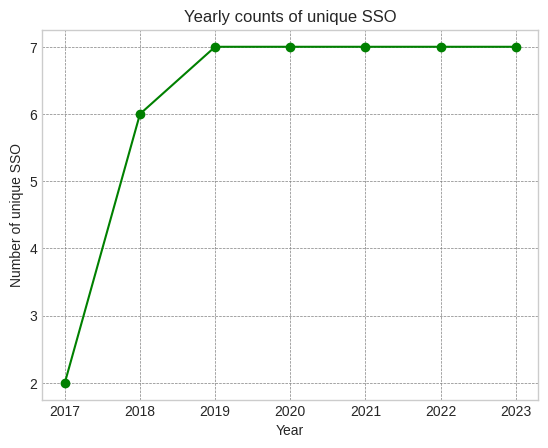

In [224]:
# generate a plot for the uniue default utilities
plot_unique_yearly_default_utilities(df)

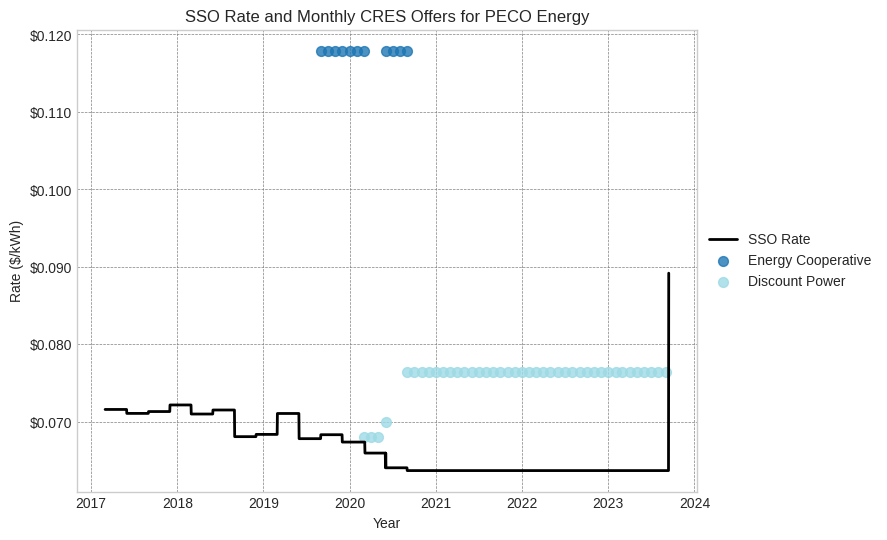

In [225]:
# compare PECo vs competitive suppliers
plot_utility_rate_comparison(df, CONFIG['utility_name'])

In [226]:
utility_medians, supplier_medians, wholesale_medians = calculate_median_rates(df, df_wholesale, CONFIG['utility_name'], 'utility_rate_amount', 'plan_rate_amount')

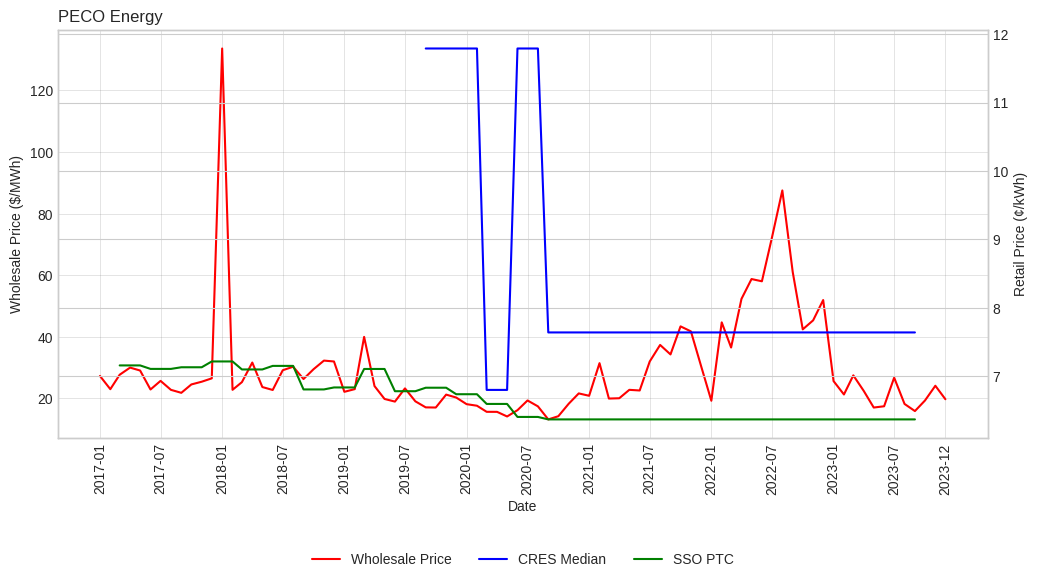

In [228]:
plot_median_rates_prices_and_wholesale_prices(
    utility_medians,
    supplier_medians,
    wholesale_medians,
    title=CONFIG['utility_name'],
    x_label='Date',
    y_label='Price ($/kWh)',
    legend_labels=('Wholesale Price', 'CRES Median', 'SSO PTC')  # Reordered labels
)

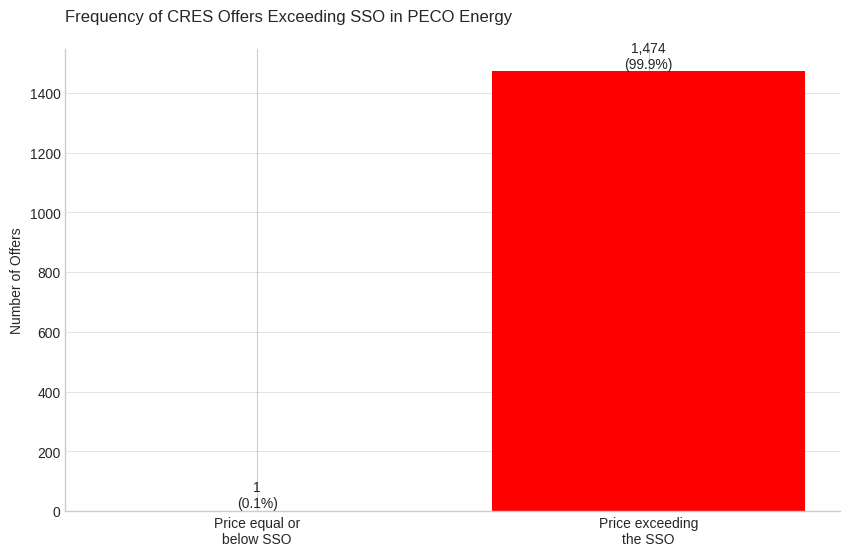

In [ ]:
below_or_equal, above = calculate_price_distribution(df, CONFIG['utility_name'], utility_medians)
plot_price_distribution(below_or_equal,above,CONFIG['utility_name'])

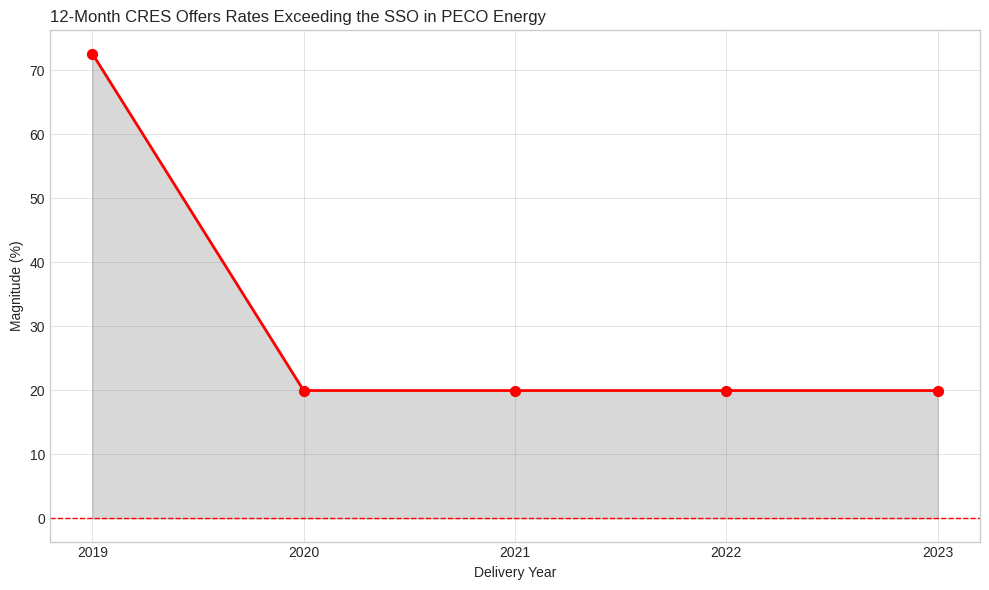

In [ ]:
yearly_markup = calculate_yearly_markup(df, CONFIG['utility_name'], utility_medians)
plot_markup_trend(yearly_markup, CONFIG['utility_name'])

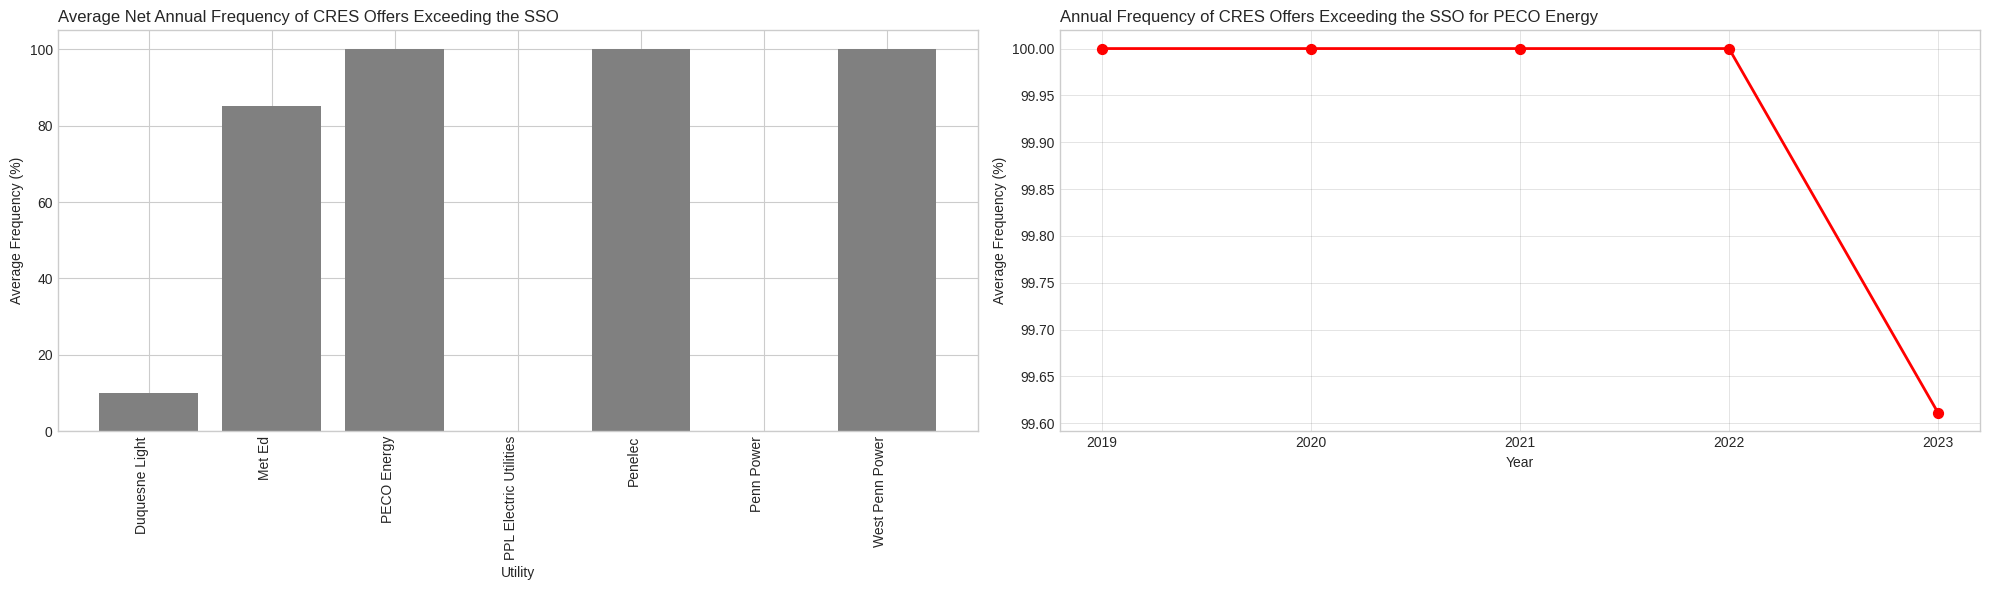

In [ ]:
# should we add the error bars here??
utility_freqs = calculate_utility_frequencies(df)
SSO_annual_freqs = calculate_annual_frequencies(df, CONFIG['utility_name'])
plot_utility_analysis(utility_freqs, SSO_annual_freqs, CONFIG['utility_name'])

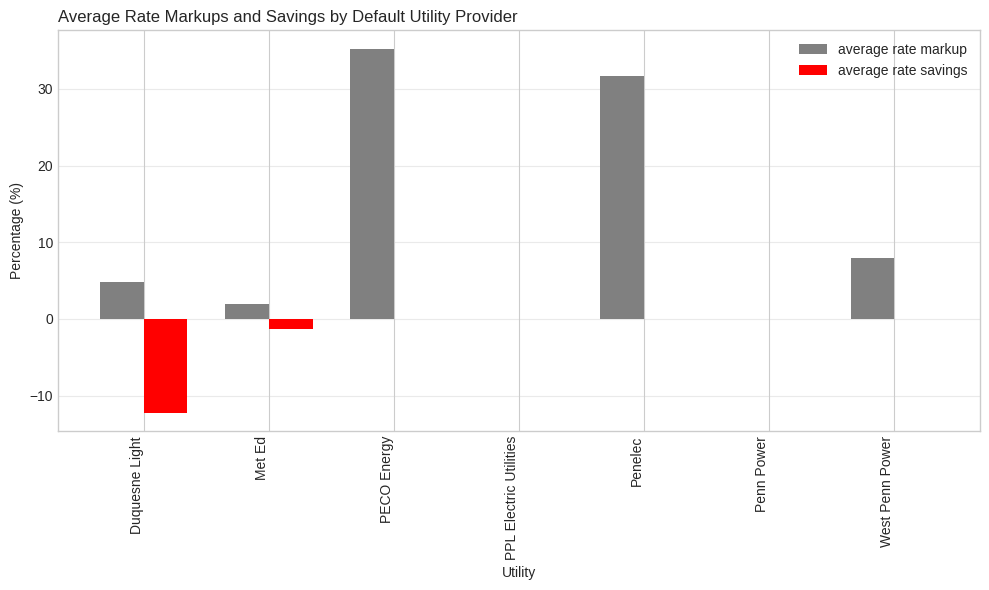

In [ ]:
markup_savings = calculate_annual_markup_savings(df)
plot_markup_savings(markup_savings)

In [ ]:
def verify_no_missing_dates(df, date_column='created_at', group_column='utility_name'):
    """
    verify that there are no missing dates in the dataframe after imputation.

    args:
        df (pd.DataFrame): dataframe to check
        date_column (str): name of the date column
        group_column (str): name of the column to group by

    returns:
        bool: True if there are no missing dates, False otherwise
    """
    df[date_column] = pd.to_datetime(df[date_column])
    missing_found = False

    for group_value in df[group_column].unique():
        group_data = df[df[group_column] == group_value]

        # Get date range
        min_date = group_data[date_column].min()
        max_date = group_data[date_column].max()

        # Create expected date range
        expected_dates = pd.date_range(start=min_date, end=max_date, freq='D')
        actual_dates = group_data[date_column].dt.normalize().sort_values().unique()

        # Find missing dates
        missing_dates = set(expected_dates) - set(actual_dates)

        if missing_dates:
            print(f"{group_value}: Missing {len(missing_dates)} dates")
            print(f"  First 5 missing: {sorted(list(missing_dates))[:5]}")
            missing_found = True

    if not missing_found:
        print("No missing dates found!")

    return not missing_found

verify_no_missing_dates(df_wholesale)

No missing dates found!


True

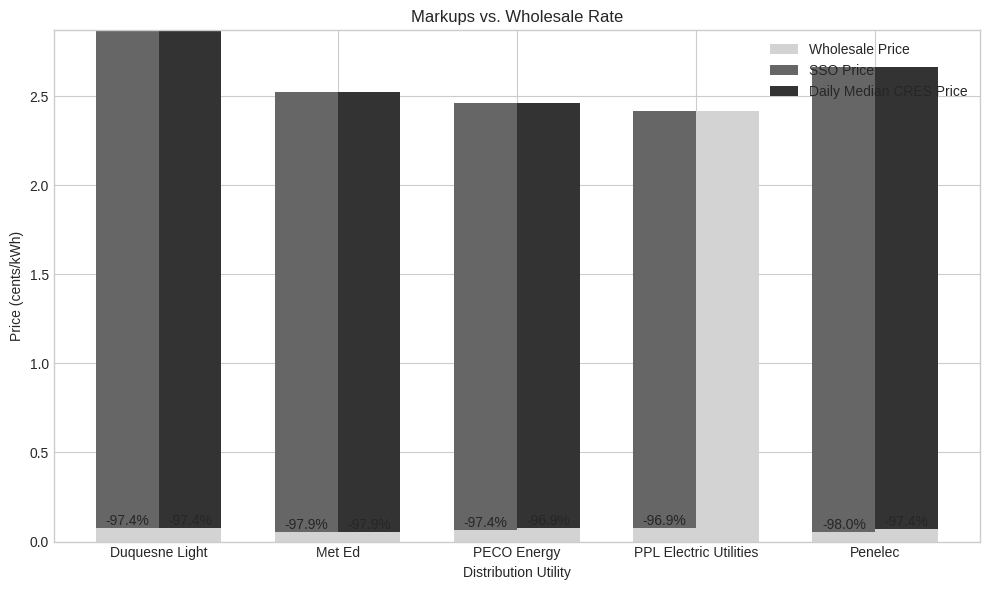

In [ ]:
# # daily wholesale prices
# wholesale_prices = create_daily_wholesale_prices(df)
# calculate markups
service_data = calculate_service_markups(df, df_wholesale)
plot_service_markups(service_data)

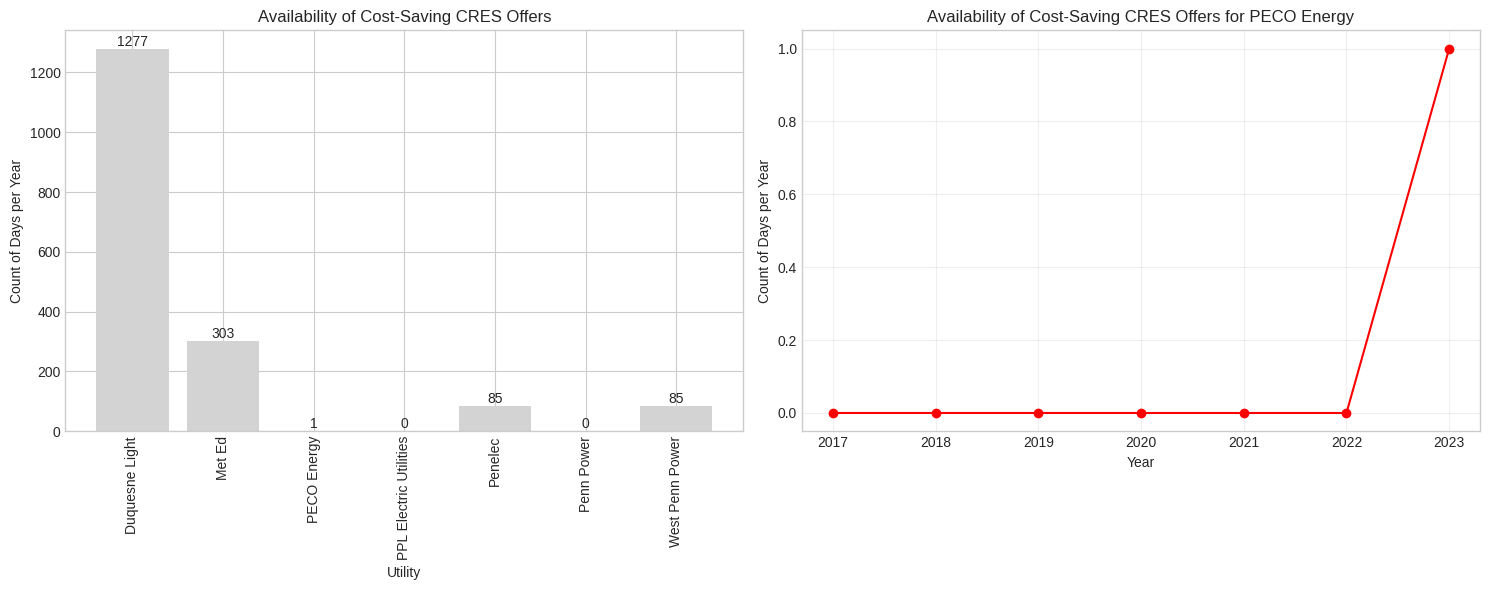

In [ ]:
# calculate daily counts in each year
utility_counts, yearly_counts = calculate_cost_saving_offers(df)
plot_cost_saving_offers(utility_counts, yearly_counts, CONFIG['utility_name'])

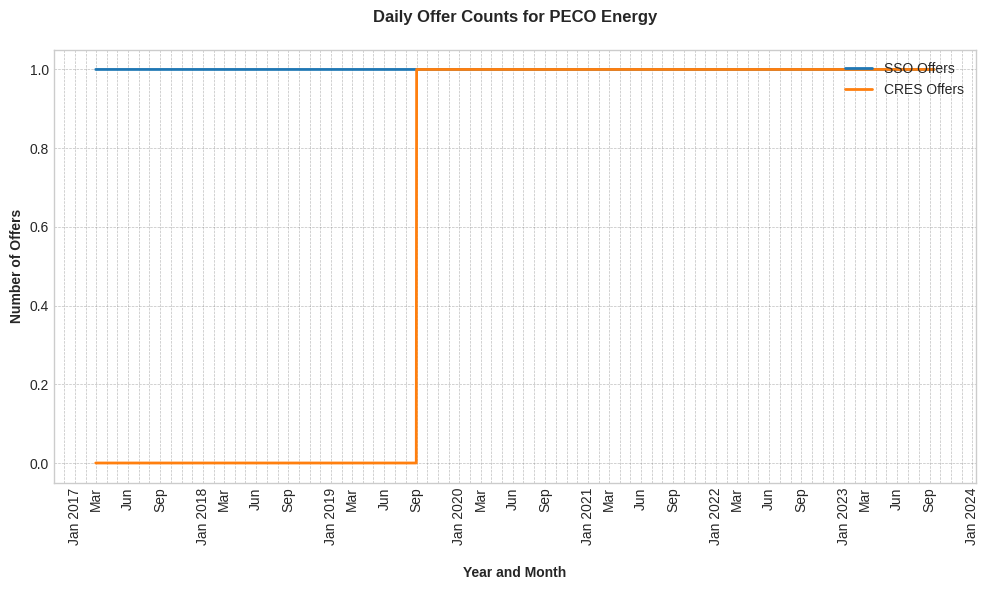

In [ ]:
plot_utility_daily_offers(df, CONFIG['utility_name'])

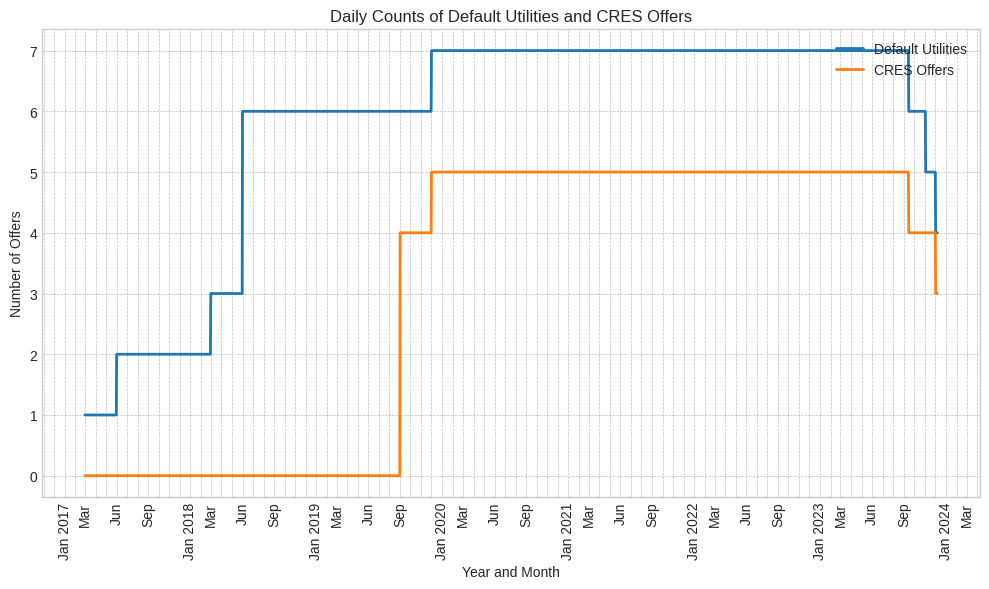

In [ ]:
plot_daily_offers_counts(df)